In [1]:
"""
In this exercise we will train some neural network using Pytorch.
Installation instructions: https://pytorch.org/get-started/locally/

I recommend to run this exercise in colab using GPU or in kaggle notebooks.
You should find something like: Runtime -> Change runtime type -> T4 GPU to access GPU there.
Everything thing you need is preinstalled there.
"""

'\nIn this exercise we will train some neural network using Pytorch.\nInstallation instructions: https://pytorch.org/get-started/locally/\n\nI recommend to run this exercise in colab using GPU or in kaggle notebooks.\nYou should find something like: Runtime -> Change runtime type -> T4 GPU to access GPU there.\nEverything thing you need is preinstalled there.\n'

In [2]:
# Because outside world is ugly (in console 'export OMP_NUM_THREADS=1')
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
# Pytorch is library for dealing with neural networks (and automatic gradients)
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torchvision is helper library for pytorch to deal with computer vision
import torchvision

import matplotlib.pyplot as plt

In [4]:
"""Prepare dataset, whole lecture will be done over MNIST dataset"""
batch_size_train = 256
batch_size_test = 1024

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

/home/usamec/anaconda3/envs/magic_train/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# What is in train?
for x, y in train_loader:
    print(x.shape, y.shape, y[:10])
    break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor([9, 5, 6, 8, 5, 1, 2, 2, 4, 3])


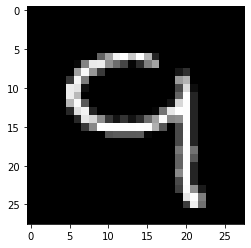

In [10]:
# X: 256 images, 1 channel (black/white), 28x28 image
# We will flatten each image into one vector for now
# Y: One number (category of image)
# Images looks like this:

plt.imshow(x[0,0], cmap="gray")

In [11]:
# Simple linear model from last lecture
# This just computes scores for each class
# This layer has parameters W, b and does (input.matmul(W.T) + b)
model_linear = nn.Linear(28*28, 10)
[(name, p.shape) for name, p in model_linear.named_parameters()]

[('weight', torch.Size([10, 784])), ('bias', torch.Size([10]))]

In [12]:
# Let's compute loss for one batch of images
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss

tensor(2.5075, grad_fn=<NllLossBackward>)

In [13]:
# Pytorch has many loss functions, which look similar but take different things,
# so take care
# Here cross entropy(output, y) is same as nll_loss(log_softmax(output), y)
loss2 = F.cross_entropy(output, y)
loss2

tensor(2.5075, grad_fn=<NllLossBackward>)

In [14]:
# If we want to train model, we need to get gradients
# This is easy, gradient will magically appear
loss.backward()
model_linear.weight.grad

# If you really want to do things by hand
# model_linear.weight.data = model_linear.weight.data - 0.01 * model_linear.weight.grad

tensor([[-0.0329, -0.0329, -0.0329,  ..., -0.0329, -0.0329, -0.0329],
        [ 0.0016,  0.0016,  0.0016,  ...,  0.0016,  0.0016,  0.0016],
        [ 0.0044,  0.0044,  0.0044,  ...,  0.0044,  0.0044,  0.0044],
        ...,
        [ 0.0147,  0.0147,  0.0147,  ...,  0.0147,  0.0147,  0.0147],
        [ 0.0062,  0.0062,  0.0062,  ...,  0.0062,  0.0062,  0.0062],
        [ 0.0087,  0.0087,  0.0087,  ...,  0.0087,  0.0087,  0.0087]])

In [15]:
# If we calculate gradient second time, it will accumulate
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss.backward()
model_linear.weight.grad

tensor([[-0.0658, -0.0658, -0.0658,  ..., -0.0658, -0.0658, -0.0658],
        [ 0.0033,  0.0033,  0.0033,  ...,  0.0033,  0.0033,  0.0033],
        [ 0.0088,  0.0088,  0.0088,  ...,  0.0088,  0.0088,  0.0088],
        ...,
        [ 0.0294,  0.0294,  0.0294,  ...,  0.0294,  0.0294,  0.0294],
        [ 0.0124,  0.0124,  0.0124,  ...,  0.0124,  0.0124,  0.0124],
        [ 0.0173,  0.0173,  0.0173,  ...,  0.0173,  0.0173,  0.0173]])

In [16]:
# Lets optimize, this is typical pytorch training loop you will see a lot with some modifications
model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(5):
    total_loss = 0
    total_loss_cc = 0
    for x, y in train_loader:
        # Here we calculate output from the model, note that we flatten the input (converts 256,1,28,28 to 256,784) 
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        # Here we calculate loss
        batch_loss = F.nll_loss(log_probs, y)
        # Here we calculate gradients, first we need to zero previous ones
        optimizer.zero_grad()
        batch_loss.backward()
        # And here we update the weights
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
    print("epoch", epoch, "training loss", total_loss / total_loss_cc)

epoch 0 training loss 2.274541570531561
epoch 1 training loss 1.2374114778447658
epoch 2 training loss 1.1863635533667625
epoch 3 training loss 1.1060615998633365
epoch 4 training loss 1.1890613818422278


In [17]:
# Optimize and compute training accuracy and test accuracy

model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        # This calulcates accuracy
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 2.009 training accuracy 0.832 testing accuracy 0.696
epoch 1 training loss 1.309 training accuracy 0.868 testing accuracy 0.856
epoch 2 training loss 1.185 training accuracy 0.878 testing accuracy 0.824
epoch 3 training loss 1.065 training accuracy 0.881 testing accuracy 0.898
epoch 4 training loss 1.154 training accuracy 0.878 testing accuracy 0.896
epoch 5 training loss 1.096 training accuracy 0.884 testing accuracy 0.877
epoch 6 training loss 1.100 training accuracy 0.885 testing accuracy 0.886
epoch 7 training loss 1.061 training accuracy 0.885 testing accuracy 0.908
epoch 8 training loss 1.115 training accuracy 0.884 testing accuracy 0.907
epoch 9 training loss 1.120 training accuracy 0.887 testing accuracy 0.890


In [20]:
model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

model(torch.randn((10,28*28)))

tensor([[-0.1063, -0.0495, -0.2421, -0.1830, -0.3833, -0.0672, -0.1323, -0.3067,
         -0.0515,  0.0095],
        [ 0.1249, -0.1272, -0.1323, -0.0771, -0.5209,  0.2859, -0.0053,  0.0159,
          0.1288, -0.0543],
        [ 0.0879,  0.1431,  0.2058,  0.0300,  0.0035, -0.4652,  0.3180, -0.0816,
          0.3194, -0.0390],
        [-0.1388, -0.0740, -0.3046,  0.2811, -0.2061,  0.4380,  0.1307,  0.0327,
         -0.0011, -0.4125],
        [ 0.1923, -0.0686, -0.1078, -0.1517, -0.0753, -0.0714,  0.2345, -0.2096,
         -0.2972, -0.2264],
        [-0.0712,  0.3517,  0.0309, -0.2169, -0.4148,  0.0008,  0.2375, -0.0196,
         -0.2262, -0.2258],
        [ 0.3602, -0.2279,  0.1028, -0.0144,  0.1959, -0.2619,  0.1685, -0.0426,
         -0.0902,  0.1854],
        [ 0.1064, -0.0445, -0.2153, -0.0236, -0.4611,  0.1382,  0.0954, -0.4292,
          0.2608,  0.0428],
        [ 0.0572, -0.0269, -0.1442,  0.3465,  0.0454, -0.0184,  0.2459, -0.0549,
         -0.0249, -0.2102],
        [ 0.0555,  

In [21]:
# Let's train neural network, we only change model and maybe learning rate

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.0)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.861 training accuracy 0.406 testing accuracy 0.465
epoch 1 training loss 1.403 training accuracy 0.500 testing accuracy 0.403
epoch 2 training loss 0.983 training accuracy 0.651 testing accuracy 0.776
epoch 3 training loss 0.513 training accuracy 0.843 testing accuracy 0.901
epoch 4 training loss 0.719 training accuracy 0.756 testing accuracy 0.707
epoch 5 training loss 0.625 training accuracy 0.793 testing accuracy 0.662
epoch 6 training loss 0.931 training accuracy 0.688 testing accuracy 0.890
epoch 7 training loss 0.563 training accuracy 0.831 testing accuracy 0.875
epoch 8 training loss 0.491 training accuracy 0.853 testing accuracy 0.829
epoch 9 training loss 0.391 training accuracy 0.900 testing accuracy 0.893


In [ ]:
"""
# How to run on cuda (this optional, if you have GPU access, vyuka does not have one, colab does)
# No need to run this cell

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code
# is nicely parametrized.

model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        # Move input and labels to GPU
        output = model(x.cuda().flatten(1))
        y = y.cuda()
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        # Move input and labels to GPU
        y = y.cuda()
        output = model(x.cuda().flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))
          
"""

In [ ]:
"""
Task 1.
In example above figure out best settings for learning rate a momentum in the optimizer.
Keep the number of epochs to 10. Also keep the learning constant during training.
Sumarize your findings in some chart or table.
"""

In [ ]:
"""
Task 2.
Here is network with 2 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

How does adding more hidden layers influence final accuracy (try 3-6 hidden layers).
Always figure out the best optimizer settings. Again run for 10 epochs.
Again produce some chart or table (maybe with accuracy changes over time).
"""

In [ ]:
"""
Task 3.
Here is an example of convolutional network. Do not change it for this task.
Only figure out best settings for the optimizer. Also run for only 10 epochs.
model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=2, stride=2),  # Here we get 14x14 image with 16 channels
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)

Run training of convolutional network and report the results and compare with best results from above.
Also, there is no need to flatten the input now. 
"""

In [26]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=1, stride=2),  # Here we get 14x14 image with 16 channels
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)
model(torch.randn(10,1,28,28)).shape

torch.Size([10, 10])

In [ ]:
"""
Task 4 bonus:
Change neural architecture like you want and achive best accuracy in 10 epochs.
"""